In [9]:
# -*- coding: utf-8 -*-
# === MLB Simulator: inputs -> CSV -> 10-event probs -> scenarios (multi-slot + slot-delta charts) ===
# In notebook before running this script:
!pip -q install MLB-StatsAPI pandas ipywidgets

import os, re, csv, json, math, random
from typing import Dict, List, Optional, Set, Tuple
import numpy as np
import pandas as pd
import statsapi

# Optional: plotting
import matplotlib.pyplot as plt

# -----------------------------
# Constants & Defaults
# -----------------------------
EVENTS = ["BB","SO","HBP","1B","2B","3B","HR","Flyout","Groundout","LineDriveOut"]

# 13->10 default league split (fallback)
THIRTEEN_TO_TEN_DEFAULT = {
    "Walk (BB)": 0.0818273793, "Strikeout (SO)": 0.2258000005, "Hit By Pitch (HBP)": 0.0110726368,
    "Single (1B)": 0.1419717019, "Double (2B)": 0.0425962292, "Triple (3B)": 0.0038200911,
    "Home Run (HR)": 0.0298887902, "Flyout (non-SF)": 0.1484230159, "Line Drive Out": 0.0642246942,
    "Sacrifice Fly (SF)": 0.0069116814, "Sacrifice Hit (SH)": 0.0024774859,
    "Groundout (non-GDP/SH)": 0.2233000144, "Grounded into Double Play (GDP)": 0.0176876802,
}

CONFIG = {
    "outputs_dir": "/content",
    "league_stats_csv": "/content/stats2024.csv",  # if absent, fallback props are used
    "n_games": 2000,
    "seed": 7,
    "dp_rate": 0.10,
    "sf_rate": 1/3,
}

# -----------------------------
# Helpers: name, search, season stats
# -----------------------------
def _slug(s: str) -> str:
    return re.sub(r'[^a-z0-9]+', '_', s.strip().lower())

def search_players(name: str) -> pd.DataFrame:
    """Return candidate players (exact match first, then active, then others)."""
    cand = statsapi.lookup_player(name)
    if not cand:
        return pd.DataFrame()
    rows = []
    for c in cand:
        rows.append({
            "personId": c.get("id"),
            "fullName": c.get("fullName"),
            "primaryNumber": c.get("primaryNumber"),
            "primaryPosition": (c.get("primaryPosition") or {}).get("abbreviation"),
            "currentTeam": (c.get("currentTeam") or {}).get("name"),
            "mlbDebutDate": c.get("mlbDebutDate"),
            "active": c.get("active")
        })
    df = pd.DataFrame(rows)
    exact = df[df["fullName"].str.lower() == name.strip().lower()]
    if not exact.empty:
        df = pd.concat([exact, df[~df.index.isin(exact.index)]], ignore_index=True)
    return df

def get_hitting_season_stats(person_id: int, season: int) -> dict:
    """
    Try season → yearByYear → REST byDateRange(3~11).
    """
    # 1) season
    try:
        d = statsapi.player_stats(person_id, group="hitting", type="season", season=season)
        splits = (d.get("stats") or [{}])[0].get("splits") or []
        for s in splits:
            if str(season) == str(s.get("season")):
                return s.get("stat", {}) or {}
        if splits:
            return splits[0].get("stat", {}) or {}
    except Exception:
        pass
    # 2) yearByYear
    try:
        d2 = statsapi.player_stats(person_id, group="hitting", type="yearByYear")
        splits2 = (d2.get("stats") or [{}])[0].get("splits") or []
        for s in splits2:
            if str(season) == str(s.get("season")):
                return s.get("stat", {}) or {}
    except Exception:
        pass
    # 3) REST byDateRange
    try:
        import requests
        url = (f"https://statsapi.mlb.com/api/v1/people/{person_id}/stats"
               f"?stats=byDateRange&group=hitting&startDate={season}-03-01&endDate={season}-11-01")
        resp = requests.get(url, timeout=15)
        if resp.status_code == 200:
            data = resp.json()
            splits = (data.get("stats") or [{}])[0].get("splits") or []
            if splits:
                return splits[0].get("stat", {}) or {}
        else:
            print("⚠️ byDateRange call failed:", resp.status_code)
    except Exception as e:
        print("⚠️ byDateRange exception:", e)
    return {}

# -----------------------------
# League outs split & p10 utilities
# -----------------------------
def read_league_batted_out_props(league_stats_file_path: str) -> Tuple[float, float, float]:
    """
    Estimate league Flyout/Groundout/LineDriveOut proportions from CSV.
    Assumes last row is totals, with columns [ .., FlyOut(4), GroundOut(5), LineDriveOut(6) ].
    If schema differs or file missing, returns fallback props.
    """
    if not os.path.exists(league_stats_file_path):
        return 0.35, 0.50, 0.15
    try:
        with open(league_stats_file_path, mode='r', encoding='utf-8-sig') as infile:
            rows = list(csv.reader(infile))
        if not rows:
            return 0.35, 0.50, 0.15
        summary_row = rows[-1]
        b_out_fly = int(summary_row[4]); b_out_gnd = int(summary_row[5]); b_out_ld = int(summary_row[6])
        total = b_out_fly + b_out_gnd + b_out_ld
        if total <= 0:
            return 0.35, 0.50, 0.15
        return b_out_fly/total, b_out_gnd/total, b_out_ld/total
    except Exception:
        return 0.35, 0.50, 0.15

def league_default_p10() -> Dict[str, float]:
    p10 = {
        "BB": THIRTEEN_TO_TEN_DEFAULT["Walk (BB)"],
        "SO": THIRTEEN_TO_TEN_DEFAULT["Strikeout (SO)"],
        "HBP": THIRTEEN_TO_TEN_DEFAULT["Hit By Pitch (HBP)"],
        "1B": THIRTEEN_TO_TEN_DEFAULT["Single (1B)"],
        "2B": THIRTEEN_TO_TEN_DEFAULT["Double (2B)"],
        "3B": THIRTEEN_TO_TEN_DEFAULT["Triple (3B)"],
        "HR": THIRTEEN_TO_TEN_DEFAULT["Home Run (HR)"],
        "Flyout": THIRTEEN_TO_TEN_DEFAULT["Flyout (non-SF)"] + THIRTEEN_TO_TEN_DEFAULT["Sacrifice Fly (SF)"],
        "Groundout": (THIRTEEN_TO_TEN_DEFAULT["Groundout (non-GDP/SH)"]
                      + THIRTEEN_TO_TEN_DEFAULT["Grounded into Double Play (GDP)"]
                      + THIRTEEN_TO_TEN_DEFAULT["Sacrifice Hit (SH)"]),
        "LineDriveOut": THIRTEEN_TO_TEN_DEFAULT["Line Drive Out"],
    }
    s = sum(p10.values())
    return {k: v/s for k, v in p10.items()}

def load_league_p10(outputs_dir: str) -> Dict[str, float]:
    path = os.path.join(outputs_dir, "league_avg_p10_2024.json")
    if os.path.exists(path):
        with open(path, "r", encoding="utf-8") as f:
            data = json.load(f)
        evs = data.get("events", EVENTS)
        probs = data.get("probabilities", [])
        if probs and len(probs) == len(evs):
            return {e: float(p) for e, p in zip(evs, probs)}
    return league_default_p10()

def load_player_p10(probs_json_path: str) -> Dict[str, float]:
    with open(probs_json_path, "r", encoding="utf-8") as f:
        d = json.load(f)
    return {e: float(p) for e, p in zip(d["events"], d["probabilities"])}

# -----------------------------
# Build 10-event CSV & JSON model
# -----------------------------
def build_player_csv_10events(player_name: str, season: int, out_csv: str,
                              league_stats_csv: Optional[str] = None) -> str:
    """name -> personID -> season stats -> 10-event count CSV"""
    df = search_players(player_name)
    if df.empty:
        raise ValueError(f"'{player_name}' not found")
    pick = df[df["active"] == True].head(1)
    if pick.empty:
        pick = df.head(1)
    pid = int(pick.iloc[0]["personId"])
    pname = pick.iloc[0]["fullName"]

    stat = get_hitting_season_stats(pid, int(season))
    if not stat:
        raise ValueError(f"{pname} {season} hitting totals not found")

    PA  = int(stat.get("plateAppearances", 0))
    H   = int(stat.get("hits", 0))
    BB  = int(stat.get("baseOnBalls", 0))
    HBP = int(stat.get("hitByPitch", 0))
    SO  = int(stat.get("strikeOuts", 0))
    _2B = int(stat.get("doubles", 0))
    _3B = int(stat.get("triples", 0))
    HR  = int(stat.get("homeRuns", 0))
    _1B = max(int(H - _2B - _3B - HR), 0)

    fly_prop, gnd_prop, ld_prop = read_league_batted_out_props(league_stats_csv or CONFIG["league_stats_csv"])
    total_outs = max(0, PA - H - BB - HBP)
    other_outs = max(0, total_outs - SO)
    out_fly = round(other_outs * fly_prop)
    out_gnd = round(other_outs * gnd_prop)
    out_ld  = other_outs - out_fly - out_gnd
    diff = other_outs - (out_fly + out_gnd + out_ld)
    if diff != 0:
        if out_fly >= out_gnd and out_fly >= out_ld:
            out_fly += diff
        elif out_gnd >= out_ld:
            out_gnd += diff
        else:
            out_ld  += diff

    out_df = pd.DataFrame([{
        "Season": int(season), "PA": PA, "H": H, "BB": BB,
        "HBP": HBP, "SO": SO, "1B": _1B, "2B": _2B, "3B": _3B, "HR": HR,
        "Flyout": out_fly, "Groundout": out_gnd, "LineDriveOut": out_ld
    }])
    out_df.to_csv(out_csv, index=False, encoding="utf-8-sig")
    print(f"✅ CSV created: {out_csv}  (player: {pname}, season={season}, PA={PA})")
    return out_csv

def create_player_model(position_file_path: str,
                        league_stats_file_path: Optional[str],
                        output_json_logits: str,
                        output_json_probs: str,
                        selected_season: int):
    """From 10-event count CSV -> probs/logits JSONs."""
    df = pd.read_csv(position_file_path)
    if df.empty:
        raise ValueError("Empty player CSV.")
    row = df.iloc[0]
    PA  = int(row.get("PA", 0))
    if PA <= 0:
        raise ValueError("PA <= 0")
    counts = {
        "BB": int(row.get("BB", 0)),
        "SO": int(row.get("SO", 0)),
        "HBP": int(row.get("HBP", 0)),
        "1B": int(row.get("1B", 0)),
        "2B": int(row.get("2B", 0)),
        "3B": int(row.get("3B", 0)),
        "HR": int(row.get("HR", 0)),
        "Flyout": int(row.get("Flyout", 0)) if "Flyout" in row else 0,
        "Groundout": int(row.get("Groundout", 0)) if "Groundout" in row else 0,
        "LineDriveOut": int(row.get("LineDriveOut", 0)) if "LineDriveOut" in row else 0,
    }
    probs = {k: (v/PA) for k, v in counts.items()}
    s = sum(probs.values())
    if s <= 0:
        raise ValueError("Zero probability mass")
    probs = {k: v/s for k, v in probs.items()}
    order = EVENTS[:]
    logits_payload = [{"event": e, "probability": probs[e], "logit": (math.log(probs[e]) if probs[e] > 0 else float('-inf'))}
                      for e in order]
    with open(output_json_logits, 'w', encoding='utf-8') as f:
        json.dump(logits_payload, f, ensure_ascii=False, indent=2)
    probs_payload = {"events": order, "probabilities": [probs[e] for e in order]}
    with open(output_json_probs, 'w', encoding='utf-8') as f:
        json.dump(probs_payload, f, ensure_ascii=False, indent=2)

def build_p10_from_inputs(
    player_name: str,
    season: int,
    outputs_dir: str = "/content",
    league_stats_csv: str = "/content/stats2024.csv",
) -> Tuple[str, Dict[str, float], str]:
    """
    1) (name, season) -> safe CSV path
    2) Build 10-event CSV
    3) Build probs/logits JSON
    4) Return (probs_json, p10_dict, player_csv_path)
    """
    os.makedirs(outputs_dir, exist_ok=True)
    safe_name = _slug(player_name)
    player_csv = os.path.join(outputs_dir, f"mlb{season}_{safe_name}_statsapi_10ev.csv")
    built_csv = build_player_csv_10events(player_name, season=season,
                                          out_csv=player_csv, league_stats_csv=league_stats_csv)
    logits_json = os.path.join(outputs_dir, f"model_{season}_player_logits.json")
    probs_json  = os.path.join(outputs_dir, "player_model_probabilities.json")
    create_player_model(position_file_path=built_csv,
                        league_stats_file_path=league_stats_csv,
                        output_json_logits=logits_json,
                        output_json_probs=probs_json,
                        selected_season=season)
    p10 = load_player_p10(probs_json)
    s = sum(p10.values())
    p10 = {k: v/s for k, v in p10.items()}
    return probs_json, p10, built_csv

# -----------------------------
# Simulator (multi-slot capable)
# -----------------------------
def force_advance(bases: Set[int], n: int = 1):
    new_bases: Set[int] = set(); runs = 0
    for b in sorted(list(bases), reverse=True):
        nb = b + n
        if nb > 3: runs += 1
        else: new_bases.add(nb)
    if n == 1: new_bases.add(1)
    return new_bases, runs

def advance_on_hit(bases: Set[int], bases_taken: int, rnd: random.Random):
    runs = 0; new_bases: Set[int] = set()
    sorted_bases = sorted(list(bases), reverse=True)
    if bases_taken == 1:
        if 3 in sorted_bases: runs += 1; sorted_bases.remove(3)
        if 2 in sorted_bases:
            if rnd.random() < 0.5: runs += 1
            else: new_bases.add(3)
            sorted_bases.remove(2)
        if 1 in sorted_bases:
            if rnd.random() < 0.5:
                if 3 in new_bases: runs += 1
                else: new_bases.add(3)
            else:
                if 2 in new_bases:
                    if 3 in new_bases: runs += 1
                    else: new_bases.add(3)
                else: new_bases.add(2)
            sorted_bases.remove(1)
        new_bases.add(1)
    elif bases_taken == 2:
        if 3 in sorted_bases: runs += 1; sorted_bases.remove(3)
        if 2 in sorted_bases: runs += 1; sorted_bases.remove(2)
        if 1 in sorted_bases:
            if rnd.random() < 0.5: runs += 1
            else: new_bases.add(3)
            sorted_bases.remove(1)
        new_bases.add(2)
    elif bases_taken == 3:
        runs += len(bases); new_bases = {3}
    else:
        runs += len(bases) + 1; new_bases = set()
    return new_bases, runs

def simulate_game(p10: Dict[str, float], innings: int = 9, seed: int = 0,
                  dp_rate: float = 0.10, sf_rate: float = 1/3,
                  inject_mode: Optional[str] = None, player_p10: Optional[Dict[str, float]] = None,
                  player_pa_per_game: int = 0, inject_slot: int = 4,
                  inject_map: Optional[Dict[int, Dict[str, float]]] = None) -> int:
    """
    inject_map: {slot:int -> p10:dict}  # multi-slot injection
    If inject_map is given, it overrides single-slot/count/all_pa injections.
    """
    rnd = random.Random(seed); runs = 0; inning = 1; slot = 1
    selected_pas = set(); pa_counter = 0
    if inject_mode == 'count' and player_p10 and player_pa_per_game > 0:
        max_pas = 50; idx = list(range(1, max_pas+1)); rnd.shuffle(idx)
        selected_pas = set(idx[:player_pa_per_game])

    def sample_event(dist: Dict[str, float]):
        r = rnd.random(); c = 0.0
        for e in EVENTS:
            c += dist[e]
            if r <= c: return e
        return EVENTS[-1]

    while inning <= innings:
        outs = 0; bases: Set[int] = set()
        while outs < 3:
            pa_counter += 1
            dist = p10
            if inject_map and slot in inject_map:
                dist = inject_map[slot]
            elif inject_mode == 'count' and player_p10 and (pa_counter in selected_pas):
                dist = player_p10
            elif inject_mode == 'slot' and player_p10 and slot == inject_slot:
                dist = player_p10
            elif inject_mode == 'all_pa' and player_p10:
                dist = player_p10

            ev = sample_event(dist)
            if ev in ("BB","HBP"):
                bases, add = force_advance(bases, 1); runs += add
            elif ev == "SO":
                outs += 1
            elif ev in ("1B","2B","3B","HR"):
                step = {"1B":1,"2B":2,"3B":3,"HR":4}[ev]
                bases, add = advance_on_hit(bases, step, rnd); runs += add
            elif ev == "Flyout":
                if outs < 2 and 3 in bases and rnd.random() < sf_rate:
                    outs += 1; runs += 1; bases = bases - {3}
                else:
                    outs += 1
            elif ev == "Groundout":
                if outs < 2 and 1 in bases and rnd.random() < dp_rate:
                    outs += 2
                    new_bases = bases - {1}; advanced: Set[int] = set(); gdp_runs = 0
                    for b in sorted(list(new_bases), reverse=True):
                        if b == 2:
                            if rnd.random() < 0.5:
                                if 3 in advanced: gdp_runs += 1
                                else: advanced.add(3)
                            else: advanced.add(2)
                        elif b == 3: gdp_runs += 1
                        else: advanced.add(b)
                    bases = advanced; runs += gdp_runs
                else:
                    outs += 1
                    if 1 in bases and outs < 3:
                        if 2 in bases:
                            if 3 not in bases: bases.add(3)
                        else: bases.add(2)
                        bases.remove(1)
            elif ev == "LineDriveOut":
                outs += 1
            slot = 1 + (slot % 9)
        inning += 1
    return runs

def simulate_many_games(n_games: int, p10: Dict[str, float], seed: int = 0,
                        dp_rate: float = 0.10, sf_rate: float = 1/3,
                        inject_mode: Optional[str] = None, player_p10: Optional[Dict[str, float]] = None,
                        player_pa_per_game: int = 0, inject_slot: int = 4,
                        inject_map: Optional[Dict[int, Dict[str, float]]] = None):
    runs = []
    for i in range(n_games):
        r = simulate_game(p10=p10, innings=9, seed=seed+i, dp_rate=dp_rate, sf_rate=sf_rate,
                          inject_mode=inject_mode, player_p10=player_p10,
                          player_pa_per_game=player_pa_per_game, inject_slot=inject_slot,
                          inject_map=inject_map)
        runs.append(r)
    arr = np.array(runs)
    return {
        "games": n_games,
        "mean_runs_per_game": arr.mean().item(),
        "std_runs": arr.std(ddof=1).item() if len(arr) > 1 else 0.0,
        "min_runs": int(arr.min()),
        "max_runs": int(arr.max()),
        "runs": runs,
    }

# -----------------------------
# Slot-delta helpers & flow
# -----------------------------
def plot_event_bar(player_name: str, p10: Dict[str, float]):
    plt.figure()
    xs = EVENTS; ys = [p10[e] for e in xs]
    plt.bar(xs, ys); plt.title(f"PA Event Probabilities — {player_name}")
    plt.ylabel("Probability"); plt.xticks(rotation=45); plt.tight_layout(); plt.show()

def compute_slot_deltas(p10_player: Dict[str, float],
                        league_p10: Dict[str, float],
                        base_mean: float,
                        n_games: int,
                        seed: int,
                        dp_rate: float,
                        sf_rate: float) -> Tuple[List[int], List[float], List[float]]:
    slots = list(range(1, 10))
    means, deltas = [], []
    for sl in slots:
        res = simulate_many_games(
            n_games, league_p10, seed=seed, dp_rate=dp_rate, sf_rate=sf_rate,
            inject_map={sl: p10_player}
        )
        m = res["mean_runs_per_game"]
        means.append(m); deltas.append(m - base_mean)
    return slots, means, deltas

def plot_slot_delta_bar(title: str, slots: List[int], deltas: List[float], decimals: int = 3):
    """
    Draw slot-wise Δ runs/game as points connected by a line.
    Each point is annotated with its numeric value.
    """
    # Ensure data integrity
    if not slots or not deltas or len(slots) != len(deltas):
        raise ValueError("slots and deltas must be non-empty and have the same length")

    plt.figure()
    # Line + point markers (no explicit color or style)
    plt.plot(slots, deltas, marker='o')

    # Zero baseline
    plt.axhline(0.0, linewidth=1)

    # Annotate each point with its Δ value
    for x, y in zip(slots, deltas):
        plt.annotate(f"{y:.{decimals}f}", xy=(x, y),
                     xytext=(0, 6), textcoords="offset points",
                     ha='center', va='bottom')

    plt.title(title)
    plt.xlabel("Batting Slot (1..9)")
    plt.ylabel("Δ runs per game vs baseline")
    plt.xticks(slots)  # show integer slots on x-axis
    plt.tight_layout()
    plt.show()

def find_best_two_player_lineup(
    base_p10: Dict[str, float],
    p10_a: Dict[str, float],
    p10_b: Dict[str, float],
    n_games: int = 2000,
    seed: int = 7,
    dp_rate: float = 0.10,
    sf_rate: float = 1/3,
) -> Tuple[Tuple[int, int], float, float]:
    baseline = simulate_many_games(n_games, base_p10, seed=seed, dp_rate=dp_rate, sf_rate=sf_rate)
    base_mean = baseline["mean_runs_per_game"]
    best_combo = None; best_mean = -1e9
    for sa in range(1, 10):
        for sb in range(1, 10):
            if sa == sb: continue
            inject_map = {sa: p10_a, sb: p10_b}
            res = simulate_many_games(n_games, base_p10, seed=seed, dp_rate=dp_rate, sf_rate=sf_rate,
                                      inject_map=inject_map)
            m = res["mean_runs_per_game"]
            if m > best_mean:
                best_mean = m; best_combo = (sa, sb)
    return best_combo, baseline["mean_runs_per_game"], best_mean

def build_p10_for_many(players: List[Tuple[str, int]],
                       outputs_dir: str = "/content",
                       league_stats_csv: str = "/content/stats2024.csv") -> Dict[str, Dict[str, float]]:
    result = {}
    for nm, yr in players:
        _, p10, _ = build_p10_from_inputs(nm, int(yr), outputs_dir=outputs_dir, league_stats_csv=league_stats_csv)
        result[nm] = p10
    return result

def run_full_sequence_with_multi(
    primary_name: str,
    primary_season: int,
    extra_name: Optional[str] = None,
    extra_season: Optional[int] = None,
    league_stats_csv: str = CONFIG["league_stats_csv"],
    outputs_dir: str = CONFIG["outputs_dir"],
    n_games: int = CONFIG["n_games"],
    seed: int = CONFIG["seed"],
    dp_rate: float = CONFIG["dp_rate"],
    sf_rate: float = CONFIG["sf_rate"],
):
    # 0) p10 build
    _, p10_primary, _ = build_p10_from_inputs(primary_name, int(primary_season),
                                              outputs_dir=outputs_dir, league_stats_csv=league_stats_csv)
    league_p10 = load_league_p10(outputs_dir)
    baseline = simulate_many_games(n_games, league_p10, seed=seed, dp_rate=dp_rate, sf_rate=sf_rate)
    base_mean = baseline["mean_runs_per_game"]

    # 1) (optional text) single slot #4 delta
    sc4 = simulate_many_games(n_games, league_p10, seed=seed, dp_rate=dp_rate, sf_rate=sf_rate,
                              inject_map={4: p10_primary})
    print("=== ① slot #4 Δ ===")
    print(f"Δ vs baseline: {sc4['mean_runs_per_game'] - base_mean:.3f} runs/game\n")

    # 2) best slot for primary
    singles = []
    for sl in range(1, 10):
        r = simulate_many_games(n_games, league_p10, seed=seed, dp_rate=dp_rate, sf_rate=sf_rate,
                                inject_map={sl: p10_primary})
        singles.append((sl, r["mean_runs_per_game"]))
    singles.sort(key=lambda x: x[1], reverse=True)
    best_slot, best_mean = singles[0]
    print("=== ② primary best slot ===")
    print("Top-3:", [(s, round(m,3)) for s, m in singles[:3]])
    print(f"Best slot={best_slot}, Δ={best_mean - base_mean:.3f} runs/game\n")

    # 3) CHANGED: slot-wise Δ chart for primary (not event probs)
    slots_p, means_p, deltas_p = compute_slot_deltas(
        p10_player=p10_primary, league_p10=league_p10, base_mean=base_mean,
        n_games=n_games, seed=seed, dp_rate=dp_rate, sf_rate=sf_rate
    )
    print("=== ③ primary Δ by slot ===")
    top3_primary = sorted(zip(slots_p, means_p, deltas_p), key=lambda x: x[1], reverse=True)[:3]
    print("Top-3 (slot, mean, Δ):", [(s, round(m,3), round(d,3)) for s,m,d in top3_primary], "\n")
    plot_slot_delta_bar(f"{primary_name} — Δ runs/game by batting slot", slots_p, deltas_p)

    # 4) CHANGED: if extra player provided, plot THEIR Δ by slot (no comparison)
    if extra_name and extra_season:
        _, p10_extra, _ = build_p10_from_inputs(extra_name, int(extra_season),
                                                outputs_dir=outputs_dir, league_stats_csv=league_stats_csv)
        slots_e, means_e, deltas_e = compute_slot_deltas(
            p10_player=p10_extra, league_p10=league_p10, base_mean=base_mean,
            n_games=n_games, seed=seed, dp_rate=dp_rate, sf_rate=sf_rate
        )
        top3_extra = sorted(zip(slots_e, means_e, deltas_e), key=lambda x: x[1], reverse=True)[:3]
        print("=== ④ extra Δ by slot ===")
        print("Top-3 (slot, mean, Δ):", [(s, round(m,3), round(d,3)) for s,m,d in top3_extra], "\n")
        plot_slot_delta_bar(f"{extra_name} — Δ runs/game by batting slot", slots_e, deltas_e)



✅ CSV created: /content/mlb2024_shohei_ohtani_statsapi_10ev.csv  (player: Shohei Ohtani, season=2024, PA=731)
=== ① slot #4 Δ ===
Δ vs baseline: 0.458 runs/game

=== ② primary best slot ===
Top-3: [(1, 4.864), (2, 4.862), (4, 4.827)]
Best slot=1, Δ=0.496 runs/game

=== ③ primary Δ by slot ===
Top-3 (slot, mean, Δ): [(1, 4.864, 0.496), (2, 4.862, 0.494), (4, 4.827, 0.458)] 



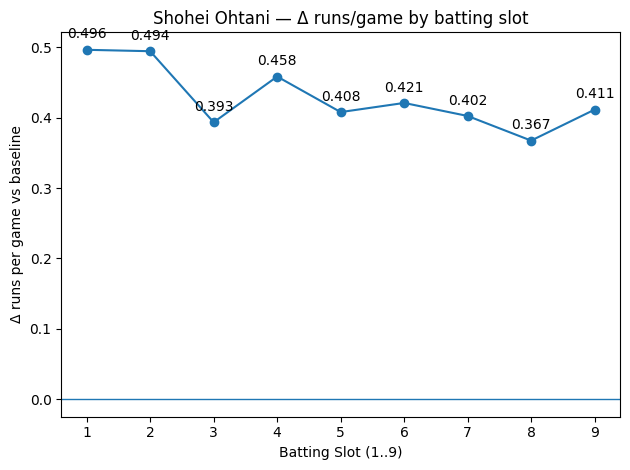

✅ CSV created: /content/mlb2024_juan_soto_statsapi_10ev.csv  (player: Juan Soto, season=2024, PA=713)
=== ④ extra Δ by slot ===
Top-3 (slot, mean, Δ): [(1, 4.859, 0.49), (4, 4.857, 0.489), (2, 4.851, 0.483)] 



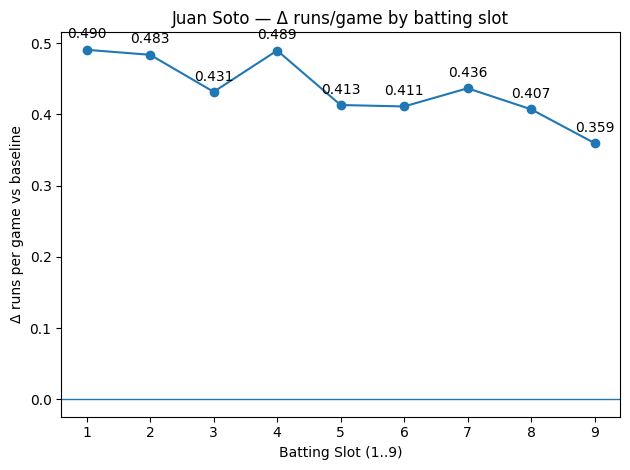

In [10]:
# -----------------------------
# Example (uncomment to run)
# -----------------------------
run_full_sequence_with_multi("Shohei Ohtani", 2024,
                             extra_name="Juan Soto", extra_season=2024)

In [13]:
# === UI: 주/추가 선수 입력 → run_full_sequence_with_multi 실행 ===
import ipywidgets as widgets
from IPython.display import display, clear_output

# 기본값은 예시
p_name = widgets.Text(value="Shohei Ohtani", description="선수1:")
p_year = widgets.BoundedIntText(value=2024, min=1900, max=2100, description="연도1:")

e_name = widgets.Text(value="Juan Soto", description="선수2(선택):")
e_year = widgets.BoundedIntText(value=2024, min=1900, max=2100, description="연도2:")

# 시뮬 파라미터(원하면 숨겨도 됨)
n_games_ui = widgets.BoundedIntText(value=CONFIG["n_games"], min=200, max=20000, step=100, description="n_games:")
seed_ui    = widgets.IntText(value=CONFIG["seed"], description="seed:")
dp_ui      = widgets.FloatSlider(value=float(CONFIG["dp_rate"]), min=0.0, max=0.5, step=0.01, description="DP")
sf_ui      = widgets.FloatSlider(value=float(CONFIG["sf_rate"]), min=0.0, max=1.0, step=0.05, description="SF")

run_btn = widgets.Button(description="분석 실행", button_style="primary")
out_box = widgets.Output()

def _on_run_click(_):
    with out_box:
        clear_output()
        # CONFIG 동기화(원하면 주석처리 가능)
        CONFIG["n_games"] = int(n_games_ui.value)
        CONFIG["seed"]    = int(seed_ui.value)
        CONFIG["dp_rate"] = float(dp_ui.value)
        CONFIG["sf_rate"] = float(sf_ui.value)

        primary = p_name.value.strip()
        extra   = e_name.value.strip()
        if not primary:
            print("⚠️ 선수1 이름을 입력하세요.")
            return

        # extra가 비어있으면 None 전달
        extra_name   = (extra if extra else None)
        extra_season = (int(e_year.value) if extra else None)

        # 기존 파이프라인 실행
        run_full_sequence_with_multi(
            primary_name=primary,
            primary_season=int(p_year.value),
            extra_name=extra_name,
            extra_season=extra_season,
            league_stats_csv=CONFIG["league_stats_csv"],
            outputs_dir=CONFIG["outputs_dir"],
            n_games=CONFIG["n_games"],
            seed=CONFIG["seed"],
            dp_rate=CONFIG["dp_rate"],
            sf_rate=CONFIG["sf_rate"],
        )

run_btn.on_click(_on_run_click)

# ---- Layout (앞서 사용한 레이아웃과 유사하게) ----
left = widgets.VBox([
    widgets.HTML("<b>선수 입력</b>"),
    p_name, p_year,
    e_name, e_year,
    widgets.HTML("<hr><b>시뮬레이션 설정</b>"),
    n_games_ui, seed_ui, dp_ui, sf_ui,
    run_btn
])

ui = widgets.HBox([left])
display(ui, out_box)


Output()

In [11]:
# === UI: per-slot lineup selector (League Avg or added players) and simulator run ===
import ipywidgets as widgets
from IPython.display import display, clear_output
import matplotlib.pyplot as plt

# Internal state: name -> p10 dict
players_p10 = {}   # e.g., {"Shohei Ohtani (2024)": p10_dict, ...}
league_p10  = load_league_p10(CONFIG["outputs_dir"])

# ---- Controls: add player (name + season) ----
name_in   = widgets.Text(value="", description="선수이름:")
season_in = widgets.BoundedIntText(value=2024, min=1900, max=2100, step=1, description="연도:")
add_btn   = widgets.Button(description="선수 추가", button_style="primary")

# ---- Controls: n_games and seed (optional tuning) ----
n_games_in = widgets.BoundedIntText(value=CONFIG["n_games"], min=100, max=20000, step=100, description="시뮬횟수:")
seed_in    = widgets.IntText(value=CONFIG["seed"], description="시드:")

# ---- Lineup selectors for slots 1..9 ----
def lineup_options():
    # "리그 평균" + current players (sorted by label)
    opts = ["리그 평균"] + sorted(players_p10.keys())
    return [(opt, opt) for opt in opts]  # (label, value)

slot_dds = [widgets.Dropdown(options=lineup_options(), value="리그 평균", description=f"{i}번:")
            for i in range(1, 10)]

# ---- Run button & output area ----
run_btn   = widgets.Button(description="시뮬레이션 실행", button_style="success")
out_area  = widgets.Output()

# ---- Helper: refresh all slot dropdown options after adding a player ----
def _refresh_lineup_dropdowns():
    opts = lineup_options()
    for dd in slot_dds:
        cur = dd.value
        dd.options = opts
        # keep previous value if still present
        valid_values = [v for (_, v) in opts]
        dd.value = cur if cur in valid_values else "리그 평균"

# ---- Add player callback ----
def _on_add_player(_):
    with out_area:
        clear_output()
        try:
            nm = name_in.value.strip()
            yr = int(season_in.value)
            if not nm:
                print("⚠️ 선수 이름을 입력하세요.")
                return
            # Build p10 using existing pipeline
            _, p10, _ = build_p10_from_inputs(nm, yr,
                                              outputs_dir=CONFIG["outputs_dir"],
                                              league_stats_csv=CONFIG["league_stats_csv"])
            label = f"{nm} ({yr})"
            players_p10[label] = p10
            _refresh_lineup_dropdowns()
            print(f"✅ 추가됨: {label}")
        except Exception as e:
            print("⚠️ 에러:", e)

add_btn.on_click(_on_add_player)

# ---- Simulation run callback ----
def _on_run(_):
    with out_area:
        clear_output()
        try:
            n_games = int(n_games_in.value)
            seed    = int(seed_in.value)

            # Baseline (league avg everywhere)
            baseline = simulate_many_games(
                n_games=n_games,
                p10=league_p10,
                seed=seed,
                dp_rate=CONFIG["dp_rate"],
                sf_rate=CONFIG["sf_rate"]
            )
            base_mean = baseline["mean_runs_per_game"]

            # Build inject_map from slot selectors
            inject_map = {}
            for i, dd in enumerate(slot_dds, start=1):
                sel = dd.value
                if sel != "리그 평균":
                    inject_map[i] = players_p10[sel]

            # Run scenario
            scenario = simulate_many_games(
                n_games=n_games,
                p10=league_p10,
                seed=seed,
                dp_rate=CONFIG["dp_rate"],
                sf_rate=CONFIG["sf_rate"],
                inject_map=inject_map if inject_map else None
            )

            # Print summary
            print("=== Lineup ===")
            for i, dd in enumerate(slot_dds, start=1):
                print(f"{i}번: {dd.value}")
            print("\n=== Results ===")
            print(f"Baseline mean runs/game : {base_mean:.3f}")
            print(f"Scenario mean runs/game : {scenario['mean_runs_per_game']:.3f}")
            print(f"Δ (scenario - baseline) : {scenario['mean_runs_per_game'] - base_mean:.3f} runs/game")

            # Optional: distribution histogram
            plt.figure()
            bins = range(0, max(max(baseline['runs']), max(scenario['runs'])) + 2)
            plt.hist(baseline["runs"], bins=bins, alpha=0.6, label="Baseline")
            plt.hist(scenario["runs"], bins=bins, alpha=0.6, label="Scenario")
            plt.title("Per-game runs distribution")
            plt.xlabel("Runs in a game")
            plt.ylabel("Frequency")
            plt.legend()
            plt.tight_layout()
            plt.show()

        except Exception as e:
            print("⚠️ 에러:", e)

run_btn.on_click(_on_run)

# ---- Layout ----
left_box  = widgets.VBox([widgets.HTML("<b>선수 추가</b>"), name_in, season_in, add_btn,
                          widgets.HTML("<hr><b>시뮬레이션 설정</b>"), n_games_in, seed_in])
right_box = widgets.VBox([widgets.HTML("<b>타순 선택 (1..9)</b>")] + slot_dds + [run_btn])
ui = widgets.HBox([left_box, widgets.HTML("&nbsp;&nbsp;&nbsp;"), right_box])

display(ui, out_area)


Output()

In [12]:
# ============================================================
# 최적 타순 탐색 UI + 로직 (기존 함수 재사용, 짧은 이름)
# ============================================================
import itertools, traceback, math
import ipywidgets as widgets
from IPython.display import display, clear_output
import numpy as np
import pandas as pd

# ---- 위젯 생성 (중복생성 방지용 close 처리)
try:
    opt_title.close(); pick_players.close(); opt_games.close()
    opt_dp.close(); opt_sf.close(); opt_seed.close()
    btn_optimize.close(); box_out_opt.close()
except Exception:
    pass

opt_title = widgets.HTML("<h4>🔎 최적 타순 탐색</h4>")

# 현재 추가된 선수 목록(players_p10 dict)에서 선택
def _player_labels():
    # earlier UI stores players as keys like "Shohei Ohtani (2024)"
    # exclude '리그 평균'
    return sorted([k for k in players_p10.keys() if k != "리그 평균"])

pick_players = widgets.SelectMultiple(
    options=_player_labels(),
    description="선수 선택",
    rows=8,
    layout=widgets.Layout(width="320px")
)

# 탐색/시뮬 파라미터
opt_games = widgets.IntSlider(value=1000, min=200, max=5000, step=200, description="opt_n_games")
opt_dp    = widgets.FloatSlider(value=float(CONFIG["dp_rate"]), min=0.0, max=0.5, step=0.01, description="DP rate")
opt_sf    = widgets.FloatSlider(value=float(CONFIG["sf_rate"]), min=0.0, max=1.0, step=0.05, description="SF rate")
opt_seed  = widgets.IntText(value=int(CONFIG["seed"]), description="seed")

btn_optimize = widgets.Button(description="최적 타순 찾기", button_style="warning", icon="search")
box_out_opt  = widgets.Output(layout={'border':'1px solid #ddd'})

# ---- 유틸: 라인업 평균 득점 평가 (simulate_many_games 재사용)
def eval_lineup_mean(lineup_map: dict, *, n_games: int, dp_rate: float, sf_rate: float, seed: int) -> float:
    """
    lineup_map: {slot:int -> p10_dict} for players; other slots are league avg
    -> 평균 득점 반환
    """
    res = simulate_many_games(
        n_games=n_games, p10=league_p10, seed=seed,
        dp_rate=dp_rate, sf_rate=sf_rate,
        inject_map=(lineup_map if lineup_map else None)
    )
    return float(res["mean_runs_per_game"])

def comb_count(n: int, k: int) -> int:
    # C(n,k) * k!
    from math import comb, factorial
    return comb(n, k) * factorial(k)

# ---- 메인 콜백: 최적 타순 탐색
def on_click_optimize(_):
    with box_out_opt:
        clear_output(wait=True)
        print("🚀 최적화 시작…")
        try:
            selected = list(pick_players.value)
            if len(selected) == 0:
                print("⚠️ 최소 1명의 선수를 선택하세요.")
                return

            # 준비: 파라미터/베이스라인
            n_games = int(opt_games.value)
            dp_rate = float(opt_dp.value)
            sf_rate = float(opt_sf.value)
            seed    = int(opt_seed.value)

            # 선수 p10 맵 (label -> p10)
            p10_map = {name: players_p10[name] for name in selected}

            # 베이스라인(모든 슬롯 리그 평균)
            base_mean = eval_lineup_mean({}, n_games=n_games, dp_rate=dp_rate, sf_rate=sf_rate, seed=seed)
            print(f"📏 베이스라인 : {base_mean:.4f} runs/game (opt_n_games={n_games})")

            m = len(selected)
            total_cands = comb_count(9, m)
            exact = (m <= 5)
            if exact:
                print(f"🔢 후보 라인업 수 (정확 탐색): C(9,{m}) × {m}! = {total_cands}")
            else:
                print(f"🔢 후보가 매우 많습니다(m={m}). 무작위 탐색으로 전환합니다.")

            slots = list(range(1, 10))
            best_mean = -1e9
            best_assign = None
            evaluated = 0

            if exact:
                # 완전 탐색
                for comb_slots in itertools.combinations(slots, m):
                    for perm_players in itertools.permutations(selected, m):
                        assign = {s: p for s, p in zip(comb_slots, perm_players)}  # {slot: label}
                        inject_map = {s: p10_map[name] for s, name in assign.items()}
                        mean_runs = eval_lineup_mean(inject_map, n_games=n_games, dp_rate=dp_rate, sf_rate=sf_rate, seed=seed)
                        evaluated += 1
                        if evaluated % 50 == 0:
                            print(f"…평가 {evaluated}/{total_cands}개 완료 (현재 최고 {best_mean:.4f})")
                        if mean_runs > best_mean:
                            best_mean, best_assign = mean_runs, assign
            else:
                # 무작위 샘플링
                max_eval = 20000
                rnd = random.Random(seed ^ 0xBEEF)
                while evaluated < max_eval:
                    comb_slots = rnd.sample(slots, m)
                    perm_players = selected[:] ; rnd.shuffle(perm_players)
                    assign = {s: p for s, p in zip(comb_slots, perm_players)}
                    inject_map = {s: p10_map[name] for s, name in assign.items()}
                    mean_runs = eval_lineup_mean(inject_map, n_games=n_games, dp_rate=dp_rate, sf_rate=sf_rate, seed=seed)
                    evaluated += 1
                    if evaluated % 200 == 0:
                        print(f"…랜덤 평가 {evaluated}/{max_eval}개 (현재 최고 {best_mean:.4f})")
                    if mean_runs > best_mean:
                        best_mean, best_assign = mean_runs, assign

            if not best_assign:
                print("❌ 유효한 배치를 찾지 못했습니다.")
                return

            # 결과 표/텍스트
            lineup_names = [best_assign.get(i, "리그 평균") for i in range(1, 10)]
            delta = best_mean - base_mean

            print("\n=== 🔥 최적 타순 결과 ===")
            print(f"Baseline Avg Runs/Game : {base_mean:.4f}")
            print(f"Scenario Avg Runs/Game : {best_mean:.4f}")
            print(f"Run Delta (Scenario - Baseline): {delta:+.4f} runs/game")

            df_lineup = pd.DataFrame({"Slot": list(range(1,10)), "Player": lineup_names})
            display(df_lineup)

            print("— 배치(슬롯:선수) —")
            print(", ".join([f"{i}:{lineup_names[i-1]}" for i in range(1,10)]))

            # 기존 드롭다운(slot_dds)에 반영
            for i, dd in enumerate(slot_dds, start=1):
                choice = lineup_names[i-1]
                if choice not in [v for _, v in dd.options]:
                    dd.options = [("리그 평균","리그 평균")] + [(k, k) for k in _player_labels()]
                dd.value = choice if choice in [v for _, v in dd.options] else "리그 평균"

            print("\n✅ 드롭다운에 최적 배치를 반영했습니다. "
                  "상단의 '시뮬레이션 실행' 버튼으로 현재 설정에서 정식 평가하세요.")

        except Exception as e:
            print("❌ 최적화 중 오류:")
            traceback.print_exc()

# 핸들러 등록(중복 제거)
try:
    for cb in list(btn_optimize._click_handlers.callbacks):
        btn_optimize._click_handlers.callbacks.remove(cb)
except Exception:
    pass
btn_optimize.on_click(on_click_optimize)

# UI 표시
display(widgets.VBox([
    opt_title,
    widgets.HBox([
        pick_players,
        widgets.VBox([opt_games, opt_dp, opt_sf, opt_seed, btn_optimize])
    ]),
    box_out_opt
]))
